In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error,mean_absolute_percentage_error
import os
import pickle



In [26]:
df = pd.read_csv("data/historical_data.csv")
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [27]:
print(df.shape)
df = df.dropna()
print(df.shape)

(197428, 16)
(175777, 16)


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175777 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     175777 non-null  float64
 1   created_at                                    175777 non-null  object 
 2   actual_delivery_time                          175777 non-null  object 
 3   store_id                                      175777 non-null  int64  
 4   store_primary_category                        175777 non-null  object 
 5   order_protocol                                175777 non-null  float64
 6   total_items                                   175777 non-null  int64  
 7   subtotal                                      175777 non-null  int64  
 8   num_distinct_items                            175777 non-null  int64  
 9   min_item_price                                175777 

In [29]:
#extracting hour for order created_at
df["created_at"] = pd.to_datetime(df['created_at'])
df['hour'] = df.created_at.dt.hour
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,hour
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,22
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,21
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,0
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,3
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2


In [30]:
# Creating target Variable, which is total delivery time, 
# It is the sum of "estimated_order_place_duration" and "estimated_store_to_consumer_driving_duration"
df['delivery_time'] = df.estimated_order_place_duration+df.estimated_store_to_consumer_driving_duration
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,hour,delivery_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,22,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,21,1136.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,0,735.0
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,3,1241.0
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2,651.0


In [31]:
#creating available dashers feature instead of two features "total_onshift_dashers" and "total_busy_dashers"
df['available_dashers'] = df.total_onshift_dashers-df.total_busy_dashers

In [32]:
#droppping unecessary columns
df.drop(columns = ['created_at',
                    'actual_delivery_time',
                    'max_item_price',
                    'total_onshift_dashers',
                    'total_busy_dashers',
                    "estimated_order_place_duration",
                    "estimated_store_to_consumer_driving_duration",
                    'num_distinct_items',
                    'min_item_price'], inplace = True)
df.head()

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,total_outstanding_orders,hour,delivery_time,available_dashers
0,1.0,1845,american,1.0,4,3441,21.0,22,1307.0,19.0
1,2.0,5477,mexican,2.0,1,1900,2.0,21,1136.0,-1.0
8,2.0,5477,indian,3.0,4,4771,18.0,0,735.0,2.0
14,1.0,2841,italian,1.0,1,1525,8.0,3,1241.0,-1.0
15,1.0,2841,italian,1.0,2,3620,7.0,2,651.0,0.0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175777 entries, 0 to 197427
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   store_id                  175777 non-null  int64  
 2   store_primary_category    175777 non-null  object 
 3   order_protocol            175777 non-null  float64
 4   total_items               175777 non-null  int64  
 5   subtotal                  175777 non-null  int64  
 6   total_outstanding_orders  175777 non-null  float64
 7   hour                      175777 non-null  int32  
 8   delivery_time             175777 non-null  float64
 9   available_dashers         175777 non-null  float64
dtypes: float64(5), int32(1), int64(3), object(1)
memory usage: 14.1+ MB


In [34]:
le = LabelEncoder()
df['store_primary_category'] = le.fit_transform(df['store_primary_category'])
df.head()

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,total_outstanding_orders,hour,delivery_time,available_dashers
0,1.0,1845,4,1.0,4,3441,21.0,22,1307.0,19.0
1,2.0,5477,46,2.0,1,1900,2.0,21,1136.0,-1.0
8,2.0,5477,36,3.0,4,4771,18.0,0,735.0,2.0
14,1.0,2841,38,1.0,1,1525,8.0,3,1241.0,-1.0
15,1.0,2841,38,1.0,2,3620,7.0,2,651.0,0.0


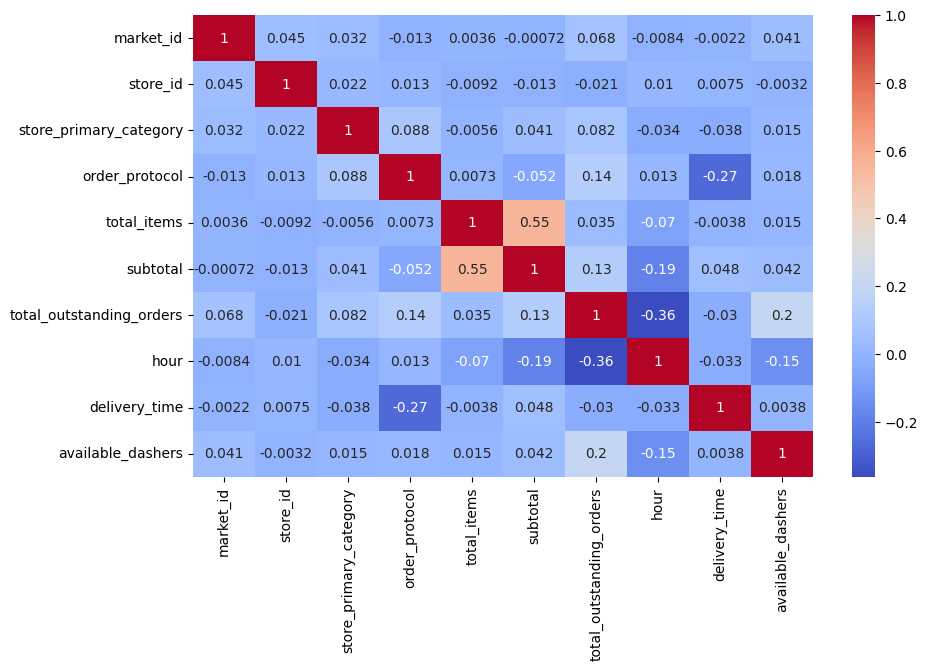

In [35]:
#checking correlation_matrix
corr_mat = df.corr()
plt.figure(figsize = (10,6))
sns.heatmap(corr_mat,annot =True,cmap ='coolwarm')
plt.show()
#Note:  Seems like features are not useful by simply looking at correlation matrix, still lets create model

In [36]:
#multicollinearity check
def compute_vif(df, features):
    """Compute VIF score using variance_inflation_factor()"""
    X = df[features]
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
vif_data = compute_vif(df.dropna(),df.columns.difference(['delivery_time']).to_list())
vif_data
#seems like no multicollinearity issue

,feature,VIF
0,subtotal,4.466191
1,market_id,4.297787
2,order_protocol,4.159963
3,store_primary_category,3.653684
4,total_items,3.514636
5,store_id,3.456201
6,total_outstanding_orders,2.598830
7,hour,2.028792
8,available_dashers,1.125405


In [37]:
x = df.drop(columns = ['delivery_time'])
y = df.delivery_time
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)
print(x.shape)
print(y.shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(175777, 9)
(175777,)
(140621, 9)
(140621,)
(35156, 9)
(35156,)


In [38]:
#scaling dataset before modeling
scaler = MinMaxScaler()
columns  = x_train.columns
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train = pd.DataFrame(x_train,columns = columns)
x_test = pd.DataFrame(x_test,columns = columns)
x_train.head()


,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,total_outstanding_orders,hour,available_dashers
0,0.2,0.311766,0.625000,0.166667,0.000000,0.030597,0.213058,0.913043,0.400000
1,0.6,0.605926,0.277778,0.333333,0.000000,0.037127,0.419244,0.086957,0.680000
2,0.0,0.226739,0.500000,0.333333,0.007317,0.076119,0.044674,0.913043,0.446667
3,0.4,0.268108,0.541667,0.000000,0.002439,0.088657,0.085911,0.130435,0.420000
4,0.2,0.563413,0.083333,0.000000,0.000000,0.053358,0.199313,0.913043,0.540000


In [53]:
#creating regression workflow
def regression(train_x,train_y,test_x,test_y,model,model_name,verbose= True):
    model.fit(train_x,train_y)
    y_predict = model.predict(train_x)
    train_RMSE = root_mean_squared_error(train_y,y_predict)
    train_MAPE = mean_absolute_percentage_error(train_y,y_predict)
    y_predict = model.predict(test_x)
    test_RMSE = root_mean_squared_error(test_y,y_predict)
    test_MAPE = mean_absolute_percentage_error(test_y,y_predict)
    if verbose:
        print(f"Train RMSE for {model_name}: {train_RMSE}")
        print(f"Train MAPE for {model_name}: {train_MAPE}")
        print(f"Test RMSE for {model_name}: {test_RMSE}")
        print(f"Test MAPE for {model_name}: {test_MAPE}")
    trained_model = model
    return trained_model,y_predict,train_RMSE,train_MAPE,test_RMSE,test_MAPE

In [ ]:
from sklearn import tree,linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

regression_models = {
    'Decision_Tree': tree.DecisionTreeRegressor(max_depth=6),
    'Linear_Regressions': linear_model.LinearRegression(),
    # "Random_Forest":RandomForestRegressor()

}

os.makedirs('models',exist_ok=True)

for model_name in regression_models.keys():
    trained_model, y_predict, _, _,_,_= regression(
        x_train, y_train, x_test, y_test,regression_models[model_name], model_name, verbose=True)
    filename = f"models/{model_name}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(trained_model, f)
    print(f'{model_name} model saved')


Train RMSE for Decision_Tree: 219.8931059999137
Train MAPE for Decision_Tree: 0.24064959789396342
Test RMSE for Decision_Tree: 220.23522407142792
Test MAPE for Decision_Tree: 0.24143747153458162
Decision_Tree model saved
Train RMSE for Linear_Regressions: 225.5793315184845
Train MAPE for Linear_Regressions: 0.2474709338823455
Test RMSE for Linear_Regressions: 225.20227224224269
Test MAPE for Linear_Regressions: 0.2475508976459431
Linear_Regressions model saved
Train RMSE for Random_Forest: 81.14886183077518
Train MAPE for Random_Forest: 0.08661145399283755
Test RMSE for Random_Forest: 216.1803010950881
Test MAPE for Random_Forest: 0.2338177373446353
Random_Forest model saved
